<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "1A"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/1A/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


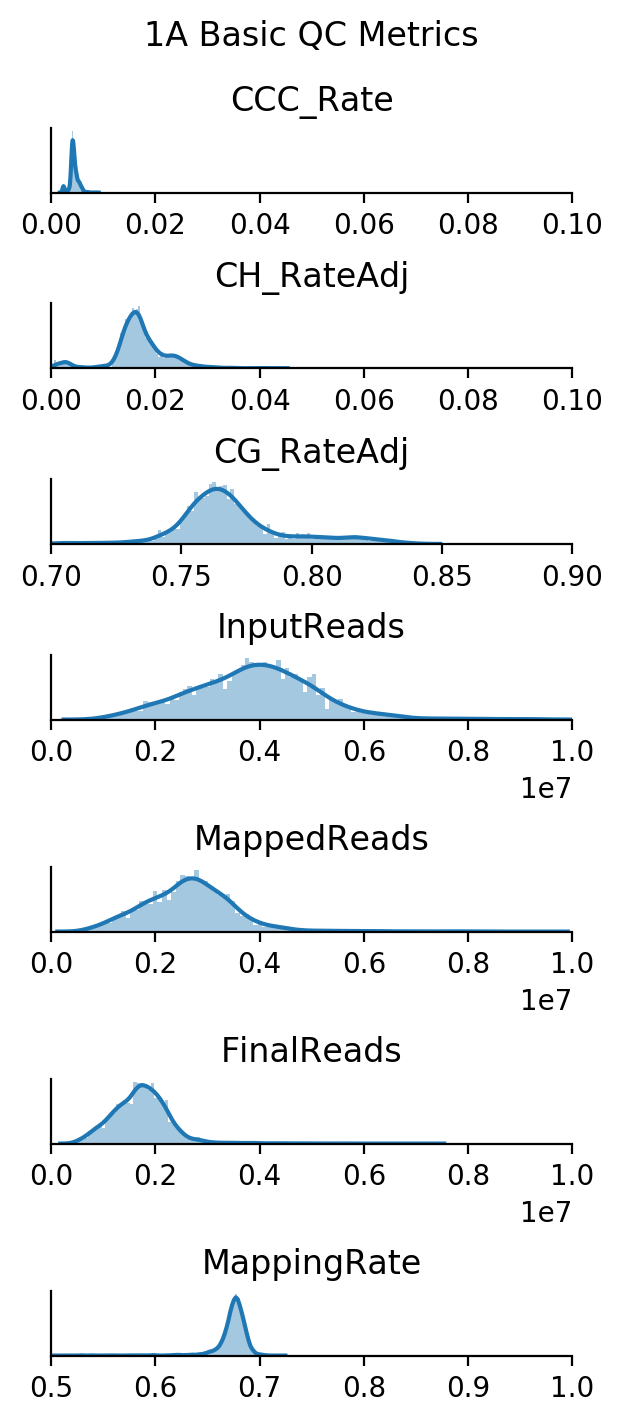

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

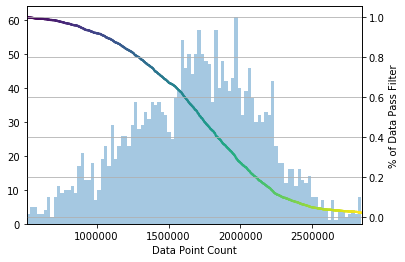

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2385/2385 (100.0%)
CG_RateAdj passed 2385/2385 (100.0%)
CH_RateAdj passed 2385/2385 (100.0%)
FinalReads passed 2385/2385 (100.0%)
MappingRate passed 2385/2385 (100.0%)
Overall passed 2385/2385 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180226 1325
180227 1060


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 295 76.8%
ad002 299 77.9%
ad004 297 77.3%
ad006 310 80.7%
ad007 294 76.6%
ad008 298 77.6%
ad010 296 77.1%
ad012 296 77.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
1A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00424,0.76626,0.76526,0.02097,0.01680,1932779.0,4061840,2765172.0,1A,...,4.680958,-14.896851,-23.386248,7.072172,IT-L4 Shc3,-5.104479,1.245065,22.172797,27.638595,True
1A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00422,0.75972,0.75870,0.02032,0.01617,1549132.0,3240886,2226396.0,1A,...,4.684537,-13.507821,-6.264395,7.254069,IT-L4 Shc3,-3.670930,-1.429920,-3.996194,36.678870,True
1A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00426,0.77770,0.77675,0.01968,0.01549,2339654.0,5217724,3577060.0,1A,...,-1.063168,-9.174500,-31.040546,35.281430,IT-L23 Cux1,4.298262,2.414790,21.864828,17.528746,True
1A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00425,0.76368,0.76267,0.01855,0.01436,2353156.0,5552334,3742394.0,1A,...,-3.020821,-8.754897,-34.883689,40.099554,IT-L23 Cux1,7.614220,4.002001,37.259851,14.266768,True
1A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00430,0.77842,0.77746,0.02109,0.01686,958205.0,2123406,1421453.0,1A,...,7.072093,-12.372558,1.988413,17.187209,IT-L5 Cdh8,-0.284260,10.215864,22.355080,-29.305726,True
1A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00450,0.76762,0.76657,0.02259,0.01817,772646.0,1686646,1142296.0,1A,...,1.270407,-11.740139,-7.461481,38.085817,IT-L23 Cux1,-1.772502,4.770433,-9.047103,-10.367370,True
1A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00499,0.78007,0.77897,0.02550,0.02061,1129187.0,2383058,1609106.0,1A,...,13.535682,-9.961327,28.746762,8.192716,IT-L5 Grik3,7.067545,-2.741640,-7.021349,41.424730,True
1A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00416,0.74495,0.74388,0.01956,0.01546,1207422.0,2472356,1706216.0,1A,...,-1.953783,-9.708794,-31.915357,37.388974,IT-L23 Cux1,5.197745,4.638354,33.055370,3.342367,True
1A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00351,0.75767,0.75682,0.01532,0.01185,980680.0,2051944,1398473.0,1A,...,-25.948494,-17.784555,-4.534514,-58.304333,CGE-Lamp5 Grk5,-0.572900,8.985583,-9.163702,3.648700,True
1A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00423,0.77055,0.76958,0.01892,0.01475,2589267.0,5371556,3726343.0,1A,...,10.791488,9.386241,48.734495,23.521392,PT-L5 Tmtc2,-9.820209,3.813857,20.767607,-12.971505,True
